In [233]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
from geopy import distance

#API keys
import api_keys

### Test geopy distance calculator

In [236]:
newport_ri = (41.5, -71.3)
cleveland_oh = (41.5, -81.7)
distance.distance(newport_ri, cleveland_oh).miles

539.2482093692297

## Import Data

In [162]:
life_exp_data = pd.read_csv('vital_zip.csv')   #Life expectancy by Zip Code
ca_search_coords = pd.read_csv('ca_search_coords.csv')   #Coordinates within California in hexagonal pattern 25 miles away from all neighoring points
zip_tract = pd.read_csv('tract_zip.csv')   #Zip Codes for US Census tracts
zip_coord = pd.read_csv('zip_coord.csv')   #Coordinates of Zip Codes

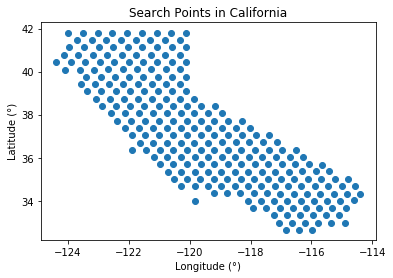

In [267]:
plt.scatter(ca_search_coords['Longitude'],ca_search_coords['Latitude'])

plt.title('Search Points in California')
plt.ylabel('Latitude (°)')
plt.xlabel('Longitude (°)')

plt.show()

In [157]:
zip_tract = zip_tract[['tract','zip']]

## Yelp Search

In [ ]:
#Yelp searchs are limited to 50 results per search and by default return 20 hits within a 25 mile radius

yelp_result = []

yelp_base_url = "https://api.yelp.com/v3/businesses/search"
headers = {
    'Authorization': "Bearer %s" % api_keys.yelp_key,
}

#--- Set search_term for Yelp search #---
                                     #---
search_term = 'museum'               #---
                                     #---
#--- Set search_term for Yelp search #---

for coord in range(ca_search_coords.shape[0]):   #Cycle through every CA search coordinate

    print(f'--- {coord + 1} ---\nlat: {ca_search_coords.loc[coord,"Latitude"]}\nlon: {ca_search_coords.loc[coord,"Longitude"]}')
    
    #   Initial hits and offset values ensure at least one search cycle will occur using a while loop
    hits = 50
    offset = -50
    
    while hits == 50:
        
        offset += hits
        print(f'ofset = {offset}')
        
        params = {
            'latitude': ca_search_coords.loc[coord,'Latitude'],
            'longitude': ca_search_coords.loc[coord,'Longitude'],
            #'location': "Los Angeles",
            'term': search_term,
            'offset': offset,
            'limit': 50
        }

        
        #print(requests.get(yelp_base_url, headers=headers, params=params).url)
        
        response = requests.get(yelp_base_url, headers=headers, params=params).json()
        
        try:
            for i in range(len(response['businesses'])):
                yelp_result.append(response['businesses'][i])
            hits = len(response['businesses'])
            print(f'results = {len(response["businesses"])}')
        except:
            break

    print(f'Total results: {len(yelp_result)}')

In [135]:
#   Put all search results in DataFrame and save to CSV file

yelp_result_list = []

for hit in range(len(yelp_result)):
    try:
        yelp_result_list.append \
        ([
            yelp_result[hit]['id'],   #ID
            yelp_result[hit]['name'],   #Name
            yelp_result[hit]['categories'][0]['alias'],   #Category search alias
            yelp_result[hit]['categories'][0]['title'],   #Category title
            yelp_result[hit]['coordinates']['latitude'],   #Latitude
            yelp_result[hit]['coordinates']['longitude'],   #Longitude
            yelp_result[hit]['location']['address1'],   #Address
            yelp_result[hit]['location']['city'],   #City
            yelp_result[hit]['location']['state'],   #State
            int(yelp_result[hit]['location']['zip_code']),   #Zip code
        ])
    except:
        next
        
yelp_result_df = pd.DataFrame \
(
    yelp_result_list,
    columns = \
    [
        'ID',
        'Name',
        'Search Alias',
        'Category',
        'Latitude',
        'Longitude',
        'Address',
        'City',
        'State',
        'Zip Code'
    ]
)

yelp_result_df.to_csv('yelp_serach_results.csv')

## Search Results Data Cleanup

In [136]:
#Number of duplicate rows due to overlap in search radius

yelp_result_df.duplicated().sum()

3558

In [137]:
#Remove rows that are exact duplicates

yelp_result_df = yelp_result_df.drop_duplicates()

In [138]:
#Keep only results in California

ca_search_result = yelp_result_df[yelp_result_df['State'] == 'CA']

In [161]:
ca_search_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698 entries, 0 to 5403
Data columns (total 10 columns):
ID              1698 non-null object
Name            1698 non-null object
Search Alias    1698 non-null object
Category        1698 non-null object
Latitude        1698 non-null float64
Longitude       1698 non-null float64
Address         1679 non-null object
City            1698 non-null object
State           1698 non-null object
Zip Code        1698 non-null int64
dtypes: float64(2), int64(1), object(7)
memory usage: 145.9+ KB


## Life Expectancy Data Cleanup

In [213]:
#Rename Zip Code column

life_exp_data = life_exp_data.rename(columns={'Zipcode': 'Zip Code'})

In [214]:
#Since multiple life expectancies are given for some Zip Codes, they are averaged

zip_grouped_life = life_exp_data.groupby(['Zip Code'])['Life Expectancy'].mean()

In [215]:
#Make into DataFrame again since .groupby meathod results in series

zip_life_df = pd.DataFrame(zip_grouped_life)

In [216]:
#Make Zip Codes a column instead of index

zip_life_df = zip_life_df.reset_index()

In [122]:
#zip_life_df['Zip Code'] = zip_life_df['Zip Code'].astype('object')

In [258]:
#Create column to mark count of search items for each zip code

zip_life_df['Count'] = [0 for i in range(zip_life_df.shape[0])]
life_v_search = zip_life_df

## Count number of search items within specified distance of each zip code in life expectancy data

In [208]:
zip_coord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43191 entries, 0 to 43190
Data columns (total 8 columns):
Zip                           43191 non-null int64
City                          43191 non-null object
State                         43191 non-null object
Latitude                      43191 non-null float64
Longitude                     43191 non-null float64
Timezone                      43191 non-null int64
Daylight savings time flag    43191 non-null int64
geopoint                      43191 non-null object
dtypes: float64(2), int64(3), object(3)
memory usage: 2.6+ MB


In [209]:
ca_search_result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698 entries, 0 to 5403
Data columns (total 10 columns):
ID              1698 non-null object
Name            1698 non-null object
Search Alias    1698 non-null object
Category        1698 non-null object
Latitude        1698 non-null float64
Longitude       1698 non-null float64
Address         1679 non-null object
City            1698 non-null object
State           1698 non-null object
Zip Code        1698 non-null int64
dtypes: float64(2), int64(1), object(7)
memory usage: 145.9+ KB


In [219]:
life_v_search.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 3 columns):
Zip Code           307 non-null int64
Life Expectancy    307 non-null float64
Museum Count       307 non-null int64
dtypes: float64(1), int64(2)
memory usage: 7.3 KB


In [ ]:
#Go through each Zip Code in life expectancy data and count how many search results are within the defined search distance
#!!! This can take a few to several minutes depending on how many search results and life expectancy data there are !!!

#Change search_radius
search_radius = 5   #Number of miles away in order to count a search result
life_v_search_5mi = life_v_search   #Make new DataFrame to prevent overwrite of original

for index_num in range(life_v_search.shape[0]):
    print(f'---- {index_num} ----')   #Print current index to monitor progress
    try:   #Record latitude and longitude for each Zip Code in life expectancy data, using Zip Code/coordinate comparison data
        lon_o = zip_coord.loc[zip_coord[zip_coord['Zip'] == life_v_search.loc[index_num, 'Zip Code']].index.values[0], 'Latitude']
        lon_o = zip_coord.loc[zip_coord[zip_coord['Zip'] == life_v_search.loc[index_num, 'Zip Code']].index.values[0], 'Longitude']
        origin = (lat_o, lon_o)
    except:
        next
    
    for result in ca_search_result.itertuples():   #Cycle through each search result
        destination = (result[5], result[6])   #Record coordinates of search result
        if distance.distance(origin, destination).miles <= search_radius:   #If distance between life expectancy Zip Code and search result are less than or equal to defined search distance...
            life_v_search_5mi.loc[index_num, 'Count'] += 1   #... add one to count for that row

In [252]:
life_v_search

,Zip Code,Life Expectancy,Museum Count
0,94002,82.550,293
1,94005,80.650,273
2,94010,82.655,278
3,94014,80.650,265
4,94015,81.340,264
...,...,...,...
302,95625,78.165,106
303,95687,78.165,119
304,95688,78.575,223
305,95690,76.470,60


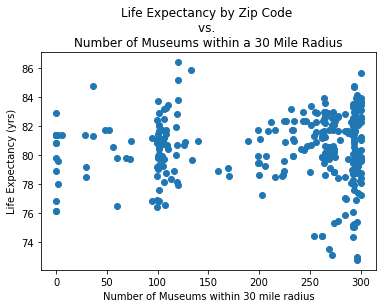

In [257]:
plt.scatter(life_v_search['Count'],life_v_search['Life Expectancy'])

plt.title('Life Expectancy by Zip Code \nvs. \nNumber of Museums within a 30 Mile Radius')
plt.ylabel('Life Expectancy (yrs)')
plt.xlabel('Number of Museums within 30 mile radius')

plt.show()

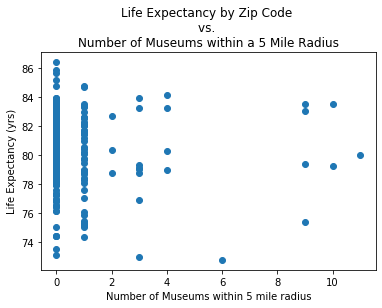

In [261]:
plt.scatter(life_v_search_5mi['Count'],life_v_search_5mi['Life Expectancy'])

plt.title('Life Expectancy by Zip Code \nvs. \nNumber of Museums within a 5 Mile Radius')
plt.ylabel('Life Expectancy (yrs)')
plt.xlabel('Number of Museums within 5 mile radius')

plt.show()